In [6]:
!sudo apt install tesseract-ocr
!pip install pytesseract
!pip install pytesseract
!pip install torchserve torch-model-archiver


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
0 upgraded, 3 newly installed, 0 to remove and 30 not upgraded.
Need to get 4,816 kB of archives.
After this operation, 15.6 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-eng all 1:4.00~git30-7274cfa-1.1 [1,591 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-osd all 1:4.00~git30-7274cfa-1.1 [2,990 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr amd64 4.1.1-2.1build1 [236 kB]
Fetched 4,816 kB in 1s (5,226 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debc

In [67]:
# handler.py
from typing import Dict, List, Any
from transformers import LayoutLMForTokenClassification, LayoutLMv2Processor
import torch
from torchvision.transforms import functional as F
from transformers import AutoTokenizer, pipeline
from ts.torch_handler.base_handler import BaseHandler
from PIL import Image
import pytesseract


from PIL import Image, ImageDraw, ImageFont

# draw results on image
def draw_result(path_to_image,result):
  image = Image.open(path_to_image)
  label2color = {
      "B-HEADER": "blue",
      "B-QUESTION": "red",
      "B-ANSWER": "green",
      "I-HEADER": "blue",
      "I-QUESTION": "red",
      "I-ANSWER": "green",
  }

  # draw predictions over the image
  draw = ImageDraw.Draw(image)
  font = ImageFont.load_default()
  for res in result:
      draw.rectangle(res["bbox"], outline="black")
      draw.rectangle(res["bbox"], outline=label2color[res["label"]])
      draw.text((res["bbox"][0] + 10, res["bbox"][1] - 10), text=res["label"], fill=label2color[res["label"]], font=font)
  return image



# helper function to unnormalize bboxes for drawing onto the image
def unnormalize_box(bbox, width, height):
    return [
        width * (bbox[0] / 1000),
        height * (bbox[1] / 1000),
        width * (bbox[2] / 1000),
        height * (bbox[3] / 1000),
    ]

class LayoutLMHandler(BaseHandler):
    def __init__(self):
        super().__init__()
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model = LayoutLMForTokenClassification.from_pretrained("philschmid/layoutlm-funsd").to(self.device)
        self.processor = LayoutLMv2Processor.from_pretrained("philschmid/layoutlm-funsd")


    def initialize(self, context):
        self.manifest = context.manifest
        properties = context.system_properties
        self.map_location = "cuda" if torch.cuda.is_available() else "cpu"
        self.model = LayoutLMForTokenClassification.from_pretrained("philschmid/layoutlm-funsd").to(self.device)
        self.processor = LayoutLMv2Processor.from_pretrained("philschmid/layoutlm-funsd")

    def preprocess(self, request):
        print('starting preprocess')
        image_bytes = base64.b64decode(request[0]["body"])
        image = Image.open(BytesIO(image_bytes))
        encoding = self.processor(image, return_tensors="pt")
        print('completed preprocess')
        return encoding

    def inference(self, model_input):
        print('starting inference')
        with torch.no_grad():
            # Prepare input data for the model
            input_ids = model_input["input_ids"].to(self.device)
            bbox = model_input["bbox"].to(self.device)
            attention_mask = model_input["attention_mask"].to(self.device)
            token_type_ids = model_input["token_type_ids"].to(self.device)

            # Perform inference
            outputs = self.model(
                input_ids=input_ids,
                bbox=bbox,
                attention_mask=attention_mask,
                token_type_ids=token_type_ids
            )

            # Post-process the outputs
            predictions = outputs.logits.softmax(-1)

        print('completed inference')

        return predictions


    def postprocess(self, inference_output,request_payload):
        print('starting postprocess')
        image_bytes = base64.b64decode(request_payload[0]["body"])
        image = Image.open(BytesIO(image_bytes))
        result = []
        for item, inp_ids, bbox in zip(
            inference_output.squeeze(0), model_input["input_ids"].squeeze(0), model_input["bbox"].squeeze(0)
        ):
            label = self.model.config.id2label[int(item.argmax().cpu())]
            if label == "O":
                continue
            score = item.max().item()
            text = self.processor.tokenizer.decode(inp_ids)
            bbox = unnormalize_box(bbox.tolist(), image.width, image.height)
            result.append({"label": label, "score": score, "text": text, "bbox": bbox})
        # Draw the results on the image
        image_with_predictions = draw_result(BytesIO(image_bytes), result)

        # Display or save the image with predictions
        image_with_predictions.save("output_image.png")
        print('completed postprocess')
        return image_with_predictions





starting preprocess
completed preprocess
starting inference
completed inference
starting postprocess
completed postprocess


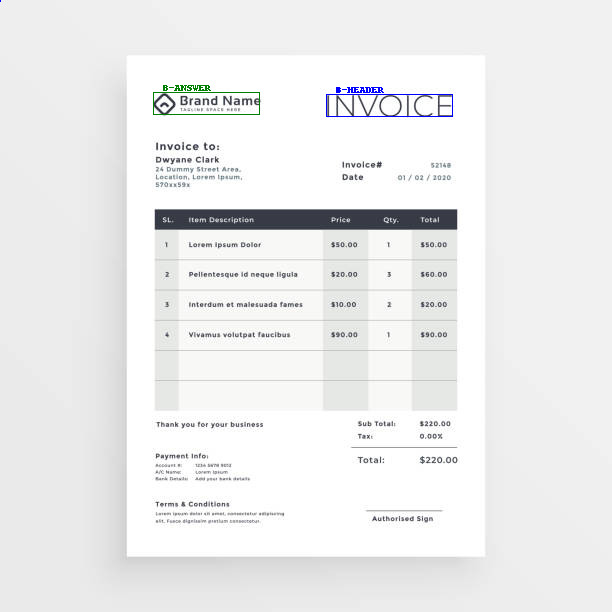

In [68]:
_service = LayoutLMHandler()

from PIL import Image
import base64
import requests

image_path = "invoice.png"
with open(image_path, "rb") as f:
    image_bytes = f.read()

# Convert image bytes to base64
image_base64 = base64.b64encode(image_bytes).decode("utf-8")

# Prepare request payload
request_payload = [
    {
        "body": image_base64
    }
]

from io import BytesIO
# Call the preprocess method (simulate TorchServe behavior)
model_input = _service.preprocess(request_payload)

# Call the inference method (simulate TorchServe behavior)
inference_output = _service.inference(model_input)

# Call the postprocess method (simulate TorchServe behavior)
result = _service.postprocess(inference_output,request_payload)

# Print the result
result

In [64]:
'''

# Extract image bytes from the request payload
image_bytes = base64.b64decode(request_payload[0]["body"])

# Draw the results on the image
image_with_predictions = draw_result(BytesIO(image_bytes), result["predictions"])

# Display or save the image with predictions
image_with_predictions.show()  # Show the image with predictions
# image_with_predictions.save("output_image.png")  # Save the image with predictions
'''

'''
image_with_predictions.save("output_image.png")
'''

'\nimage_with_predictions.save("output_image.png") \n'